In [1]:
import numpy as np
import gym
from hiive.mdptoolbox import example, mdp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from toh_gym.envs import TohEnv
from time import time

## 1. Helper Functions

In [2]:
# Unpacked from gym.unwrapped.P is a list of states. Each state has a dictionary [0,1,2,3]. Each dictionary
# contains a 4 part tuple [probability(?),new_state,reward,finished]
def getRewardProb(env):
    n_a, n_s = env.nA, env.nS
    t = np.zeros([n_a, n_s, n_s])
    r = np.zeros([n_s, n_a])
    for state in range(n_s):
        for action in range(n_a):
            for p_trans, next_state, reward, _ in env.P[state][action]:
                t[action,state,next_state] += p_trans
                r[state,action] = reward
            t[action,state,:] = t[action,state,:] / np.sum(t[action,state,:])
    return t, r

In [3]:
def runEpisodes(episodes, gamma, max_iter, R, p, n, use_vi=True, qlearn=False, epsilon=0.8):
#     (50, gamma, max_iter, r, p, n)
    n_steps = []
    successes = 0
    for episode in range(episodes):
        def convert_to_states(p, r):
            # 生成初始状态
            initial_state = tuple(tuple(range(r - 1, -1, -1)) if i == 0 else () for i in range(p))

            # 生成目标状态
            goal_state = tuple(() for _ in range(p - 1)) + (tuple(range(r - 1, -1, -1)),)

            return initial_state, goal_state
        initial_state, goal_state = convert_to_states(int(p), int(R))
        env = TohEnv(initial_state = initial_state, goal_state = goal_state, noise=n)
        env.reset()
        t, r = getRewardProb(env)
        try:
            if use_vi:
                vi = mdp.ValueIteration(t, r, gamma)
            elif use_vi and not qlearn:
                vi = mdp.PolicyIteration(t,r, gamma)
            else:
                vi = mdp.QLearning(t, r, gamma=gamma, alpha=0.1, alpha_decay=0.9999, epsilon=epsilon, epsilon_decay=0.99, n_iter=11000)
        except OverflowError as e:
#             print("Skipping because: ", e)
            continue
        vi.run()
        done = False
        state = 0
        policy = vi.policy
        t = 0
        while not done:
            action = policy[state]
            state, reward, done, info = env.step(action)
            if done:
                n_steps.append(t)
                successes += 1
                break
            if t==10000:
                n_steps.append(10000)
                break
            t += 1
    return sum(n_steps)/len(n_steps), successes/episodes

In [4]:
def valueIterateGraph(p, r, value_iterate=True):
    max_vs = []
    mean_vs = []
    errors = []
    rewards = []
    iterations = []
    gammas = list(np.arange(0.5,1,0.04))
    print(gammas)
    for gamma in gammas:
        if value_iterate:
            vi = mdp.ValueIteration(p, r, gamma)
        else:
            vi = mdp.PolicyIteration(p, r, gamma, max_iter=50)
        vi.run()
        vi.run_stats
        iterations.append(list(range(1,len(vi.run_stats)+1)))
        max_vs.append([el['Max V'] for el in vi.run_stats])
        mean_vs.append([el['Mean V'] for el in vi.run_stats])
        print(mean_vs)
        errors.append([el['Error'] for el in vi.run_stats])
        rewards.append([el['Reward'] for el in vi.run_stats])

    f, ax = plt.subplots(2,2, figsize=(15,12))
    ax[0][0].set_title("Max V", fontsize=16)
    for i in range(len(max_vs)):
        ax[0][0].plot(iterations[i], max_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][0].legend()
    ax[0][0].set_xlabel("# Iterations")

    ax[0][1].set_title("Mean V", fontsize=16)
    for i in range(len(mean_vs)):
        ax[0][1].plot(iterations[i], mean_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][1].legend()
    ax[0][1].set_xlabel("# Iterations")

    ax[1][0].set_title("Error", fontsize=16)
    for i in range(len(errors)):
        ax[1][0].plot(iterations[i], errors[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][0].legend()
    ax[1][0].set_xlabel("# Iterations")

    ax[1][1].set_title("Reward", fontsize=16)
    for i in range(len(max_vs)):
        ax[1][1].plot(iterations[i], rewards[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][1].legend()
    ax[1][1].set_xlabel("# Iterations")
    plt.plot()

## 2. Value Iteration

In [5]:
gammas_5r_3p_0n = [el/100 for el in range(1,100,5)]
n_steps_5r_3p_0n = []
success_rates_5r_3p_0n = []
r =6
p =3
n =0
max_iter= 5000
for gamma in tqdm(gammas_5r_3p_0n):
    avg_steps, success_rate = runEpisodes(50, gamma, max_iter, r, p, n)
    n_steps_5r_3p_0n.append(avg_steps)
    success_rates_5r_3p_0n.append(success_rate)

100%|██████████| 20/20 [03:00<00:00,  9.02s/it]


In [6]:
gammas_3r_3p_0n = [el/100 for el in range(1,100,5)]
n_steps_3r_3p_0n = []
success_rates_3r_3p_0n = []
r, p, n = 3, 3, 0
max_iter=5000
for gamma in tqdm(gammas_3r_3p_0n):
    avg_steps, success_rate = runEpisodes(50, gamma, max_iter, r, p, n)
    n_steps_3r_3p_0n.append(avg_steps)
    success_rates_3r_3p_0n.append(success_rate)

100%|██████████| 20/20 [00:03<00:00,  5.38it/s]


In [7]:
gammas_3r_3p_2n = [el/100 for el in range(1,100,5)]
n_steps_3r_3p_2n = []
success_rates_3r_3p_2n = []
r, p, n = 3, 3, 0.2
max_iter=5000
for gamma in tqdm(gammas_3r_3p_2n):
    avg_steps, success_rate = runEpisodes(10, gamma, max_iter, r, p, n)
    n_steps_3r_3p_2n.append(avg_steps)
    success_rates_3r_3p_2n.append(success_rate)

  0%|          | 0/20 [00:00<?, ?it/s]/home/kh/app/anaconda3/envs/assign4/lib/python3.8/site-packages/hiive/mdptoolbox/mdp.py:1564: RuntimeWarning: divide by zero encountered in scalar divide
  max_iter = (_math.log((epsilon * (1 - self.gamma) / self.gamma) /
100%|██████████| 20/20 [00:00<00:00, 35.58it/s]


In [8]:
gammas_7r_4p_2n = [el/100 for el in range(1,100,5)]
n_steps_7r_4p_2n = []
success_rates_7r_4p_2n = []
r, p, n = 6, 3, 0.2
max_iter=5000
for gamma in tqdm(gammas_7r_4p_2n):
    avg_steps, success_rate = runEpisodes(10, gamma, max_iter, r, p, n)
    n_steps_7r_4p_2n.append(avg_steps)
    success_rates_7r_4p_2n.append(success_rate)

100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Text(0.5, 0, 'Gamma')

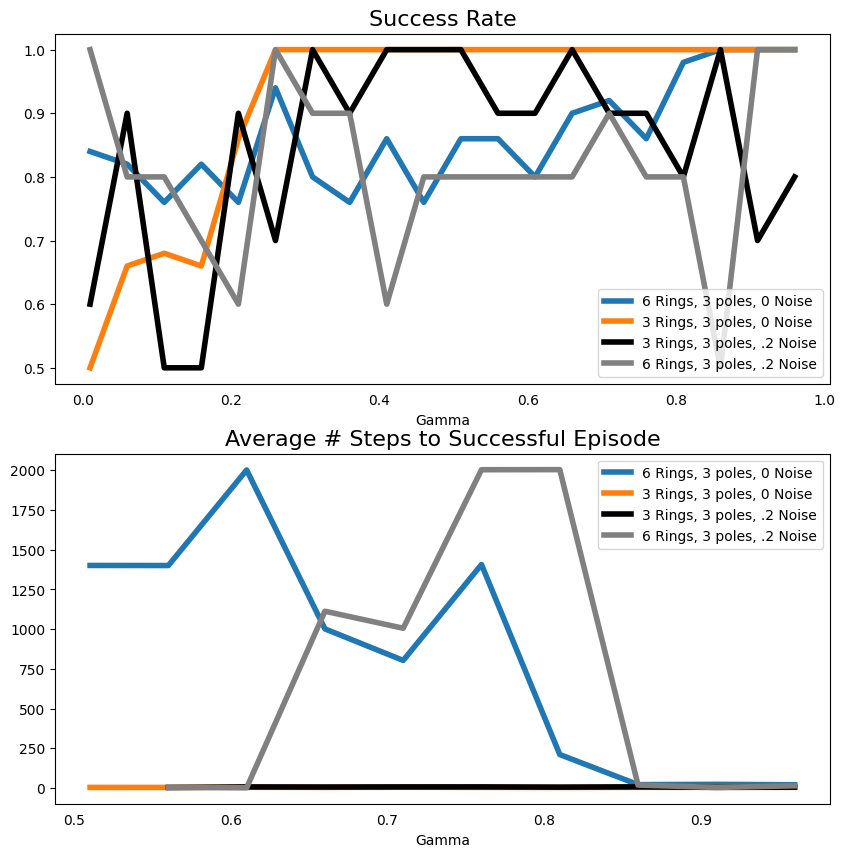

In [9]:
f, ax = plt.subplots(2, figsize=(10,10))
ax[0].set_title("Success Rate", fontsize=16)
ax[0].plot(gammas_5r_3p_0n, success_rates_5r_3p_0n, label="6 Rings, 3 poles, 0 Noise",linewidth=4)
ax[0].plot(gammas_3r_3p_0n, success_rates_3r_3p_0n, label="3 Rings, 3 poles, 0 Noise",linewidth=4)
ax[0].plot(gammas_3r_3p_2n, success_rates_3r_3p_2n, label="3 Rings, 3 poles, .2 Noise",linewidth=4, color='black')
ax[0].plot(gammas_7r_4p_2n, success_rates_7r_4p_2n, label="6 Rings, 3 poles, .2 Noise",linewidth=4, color='gray')
ax[0].tick_params(bottom=False)
ax[0].legend()
ax[0].set_xlabel("Gamma")

ax[1].set_title("Average # Steps to Successful Episode", fontsize=16)
ax[1].plot(gammas_5r_3p_0n[-10:], n_steps_5r_3p_0n[-10:], label="6 Rings, 3 poles, 0 Noise",linewidth=4)
ax[1].plot(gammas_3r_3p_0n[-10:], n_steps_3r_3p_0n[-10:], label="3 Rings, 3 poles, 0 Noise",linewidth=4)
ax[1].plot(gammas_3r_3p_2n[-9:], n_steps_3r_3p_2n[-9:], label="3 Rings, 3 poles, .2 Noise",linewidth=4, color='black')
ax[1].plot(gammas_7r_4p_2n[-9:], n_steps_7r_4p_2n[-9:], label="6 Rings, 3 poles, .2 Noise",linewidth=4, color='gray')
ax[1].tick_params(bottom=False)
ax[1].legend()
ax[1].set_xlabel("Gamma")

In [10]:
env.render()

NameError: name 'env' is not defined

In [11]:
env = TohEnv(poles=3, rings=5, noise=0.2)
env.reset()
t, r = getRewardProb(env)
valueIterateGraph(t, r)

TypeError: __init__() got an unexpected keyword argument 'poles'

## 3. Policy Iteration

In [ ]:
env = TohEnv(poles=3, rings=5, noise=0.2)
env.reset()
t, r = getRewardProb(env)
valueIterateGraph(t, r, value_iterate=False)

In [8]:
Rs = [2,3,4,5,6]
Ps = [3,4,5]
converge_times = np.zeros((2, len(Rs), len(Ps)))
for i, value_iterate in enumerate([True, False]):
    for j,R in enumerate(Rs):
        for k,P in enumerate(Ps):
            tic = time()
            print(P,R)
            def convert_to_states(p, r):
                # 生成初始状态
                initial_state = tuple(tuple(range(r - 1, -1, -1)) if i == 0 else () for i in range(p))

                # 生成目标状态
                goal_state = tuple(() for _ in range(p - 1)) + (tuple(range(r - 1, -1, -1)),)

                return initial_state, goal_state
            initial_state, goal_state = convert_to_states(int(p), int(R))
            env = TohEnv(initial_state = initial_state, goal_state = goal_state, noise=0.2)
            env.reset()
            t, r = getRewardProb(env)
            vi = mdp.PolicyIteration(t, r, 0.9, max_iter=50)
            print(i,j,k)
            converge_times[i,j,k] = time()-tic
print(converge_times)

3 2
0 0 0
4 2
0 0 1
5 2
0 0 2
3 3
0 1 0
4 3
0 1 1
5 3
0 1 2
3 4
0 2 0
4 4
0 2 1
5 4
0 2 2
3 5
0 3 0
4 5
0 3 1
5 5
0 3 2
3 6
0 4 0
4 6
0 4 1
5 6
0 4 2
3 2
1 0 0
4 2
1 0 1
5 2
1 0 2
3 3
1 1 0
4 3
1 1 1
5 3
1 1 2
3 4
1 2 0
4 4
1 2 1
5 4
1 2 2
3 5
1 3 0
4 5
1 3 1
5 5
1 3 2
3 6
1 4 0
4 6
1 4 1
5 6
1 4 2
[[[0.00248694 0.00073695 0.00062537]
  [0.00163841 0.00148654 0.00143909]
  [0.00584364 0.00501561 0.00482106]
  [0.04290295 0.11165118 0.03149891]
  [0.12894249 0.12792516 0.1175077 ]]

 [[0.00375175 0.0008986  0.00081301]
  [0.00214839 0.00233674 0.0028584 ]
  [0.00670218 0.00711465 0.00674891]
  [0.02638388 0.0265727  0.04419351]
  [0.12355471 0.13223863 0.11584902]]]


In [9]:
converge_times = np.round(converge_times, 3)

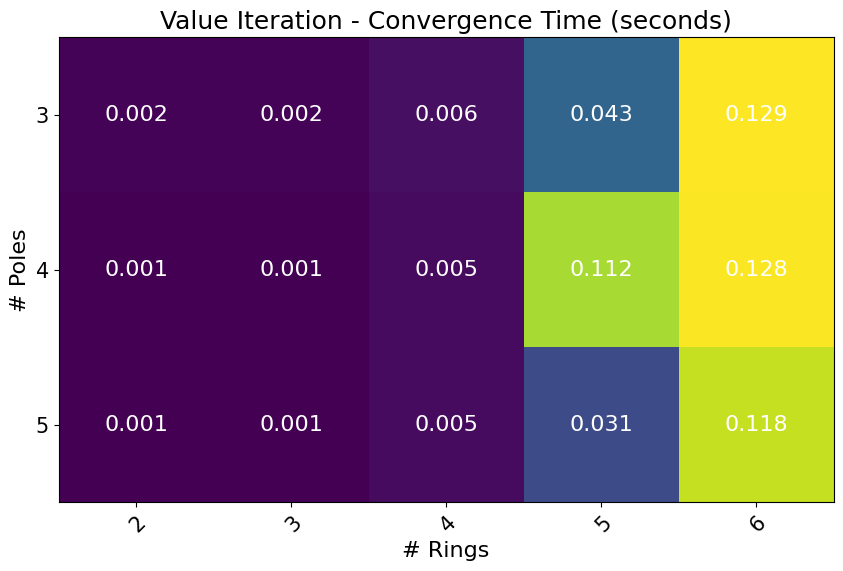

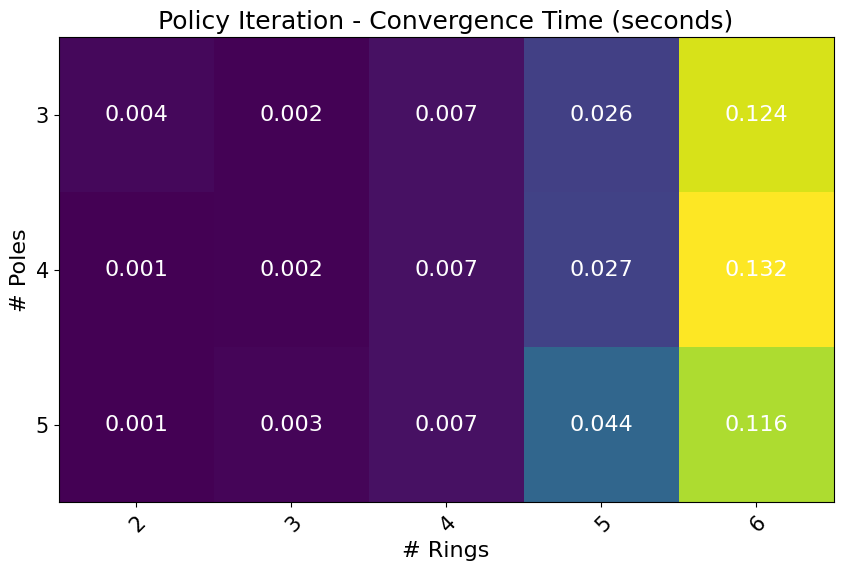

In [10]:
# Reference: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
def plot1(axis):
    f, ax = plt.subplots(1, figsize=(10,10))
    im = ax.imshow(converge_times[axis].transpose())

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(Rs)))
    ax.set_yticks(np.arange(len(Ps)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(Rs,size=15)
    ax.set_yticklabels(Ps,size=15)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(Ps)):
        for j in range(len(Rs)):
            text = ax.text(j, i, converge_times[axis, j, i],
                           ha="center", va="center", color="w",size=16)
    if axis==0:
        ax.set_title("Value Iteration - Convergence Time (seconds)",size=18)
    else:
        ax.set_title("Policy Iteration - Convergence Time (seconds)",size=18)
#     fig.tight_layout()
    ax.set_xlabel("# Rings", size=16)
    ax.set_ylabel("# Poles", size=16)
    plt.show()
plot1(0)
plot1(1)

In [11]:
gammas_5r_3p_0n = [el/100 for el in range(1,100,5)]
n_steps_5r_3p_0n = []
success_rates_5r_3p_0n = []
r =6
p =3
n =0
max_iter= 5000
for gamma in tqdm(gammas_5r_3p_0n):
    avg_steps, success_rate = runEpisodes(50, gamma, max_iter, r, p, n, use_vi=False)
    n_steps_5r_3p_0n.append(avg_steps)
    success_rates_5r_3p_0n.append(success_rate)

gammas_3r_3p_0n = [el/100 for el in range(1,100,5)]
n_steps_3r_3p_0n = []
success_rates_3r_3p_0n = []
r, p, n = 3, 3, 0
max_iter=5000
for gamma in tqdm(gammas_3r_3p_0n):
    avg_steps, success_rate = runEpisodes(50, gamma, max_iter, r, p, n, use_vi=False)
    n_steps_3r_3p_0n.append(avg_steps)
    success_rates_3r_3p_0n.append(success_rate)
    
gammas_3r_3p_2n = [el/100 for el in range(1,100,5)]
n_steps_3r_3p_2n = []
success_rates_3r_3p_2n = []
r, p, n = 3, 3, 0.2
max_iter=5000
for gamma in tqdm(gammas_3r_3p_2n):
    avg_steps, success_rate = runEpisodes(10, gamma, max_iter, r, p, n, use_vi=False)
    n_steps_3r_3p_2n.append(avg_steps)
    success_rates_3r_3p_2n.append(success_rate)

gammas_7r_4p_2n = [el/100 for el in range(1,100,5)]
n_steps_7r_4p_2n = []
success_rates_7r_4p_2n = []
r, p, n = 6, 3, 0.2
max_iter=5000
for gamma in tqdm(gammas_7r_4p_2n):
    avg_steps, success_rate = runEpisodes(10, gamma, max_iter, r, p, n, use_vi=False)
    n_steps_7r_4p_2n.append(avg_steps)
    success_rates_7r_4p_2n.append(success_rate)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:23<?, ?it/s]


KeyboardInterrupt: 

Text(0.5, 0, 'Gamma')

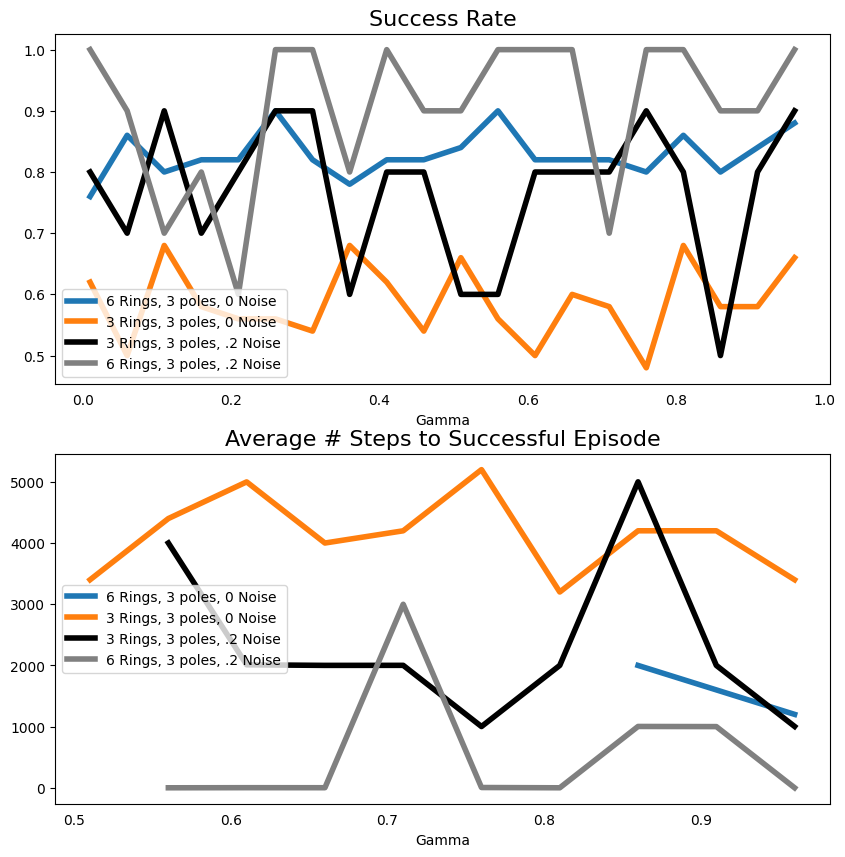

In [6]:
f, ax = plt.subplots(2, figsize=(10,10))
ax[0].set_title("Success Rate", fontsize=16)
ax[0].plot(gammas_5r_3p_0n, success_rates_5r_3p_0n, label="6 Rings, 3 poles, 0 Noise",linewidth=4)
ax[0].plot(gammas_3r_3p_0n, success_rates_3r_3p_0n, label="3 Rings, 3 poles, 0 Noise",linewidth=4)
ax[0].plot(gammas_3r_3p_2n, success_rates_3r_3p_2n, label="3 Rings, 3 poles, .2 Noise",linewidth=4, color='black')
ax[0].plot(gammas_7r_4p_2n, success_rates_7r_4p_2n, label="6 Rings, 3 poles, .2 Noise",linewidth=4, color='gray')
ax[0].tick_params(bottom=False)
ax[0].legend()
ax[0].set_xlabel("Gamma")

ax[1].set_title("Average # Steps to Successful Episode", fontsize=16)
ax[1].plot(gammas_5r_3p_0n[-3:], n_steps_5r_3p_0n[-3:], label="6 Rings, 3 poles, 0 Noise",linewidth=4)
ax[1].plot(gammas_3r_3p_0n[-10:], n_steps_3r_3p_0n[-10:], label="3 Rings, 3 poles, 0 Noise",linewidth=4)
ax[1].plot(gammas_3r_3p_2n[-9:], n_steps_3r_3p_2n[-9:], label="3 Rings, 3 poles, .2 Noise",linewidth=4, color='black')
ax[1].plot(gammas_7r_4p_2n[-9:], n_steps_7r_4p_2n[-9:], label="6 Rings, 3 poles, .2 Noise",linewidth=4, color='gray')
ax[1].tick_params(bottom=False)
ax[1].legend()
ax[1].set_xlabel("Gamma")

## 4. Q Learning

In [12]:

Rs = [2,3,4,5,6]
Ps = [3,4,5]
converge_times = np.zeros((len(Rs), len(Ps)))
for j,R in enumerate(Rs):
    for k,P in enumerate(Ps):
        tic = time()
        print(P,R)
        
        def convert_to_states(p, r):
            # 生成初始状态
            initial_state = tuple(tuple(range(r - 1, -1, -1)) if i == 0 else () for i in range(p))

            # 生成目标状态
            goal_state = tuple(() for _ in range(p - 1)) + (tuple(range(r - 1, -1, -1)),)

            return initial_state, goal_state
        initial_state, goal_state = convert_to_states(int(p), int(R))
        env = TohEnv(initial_state = initial_state, goal_state = goal_state, noise=0.2)
        env.reset()
        t, r = getRewardProb(env)
        vi = mdp.QLearning(t, r, gamma=0.99, alpha=0.1, alpha_decay=0.99999, epsilon=1, epsilon_decay=0.9999, n_iter=50000)
        converge_times[j,k] = time()-tic
print(converge_times)

3 2
4 2
5 2
3 3
4 3
5 3
3 4
4 4
5 4
3 5
4 5
5 5
3 6
4 6
5 6
[[0.00328469 0.00199556 0.00132394]
 [0.00165915 0.00154042 0.00146341]
 [0.00471425 0.00520134 0.00473833]
 [0.01760149 0.01739168 0.01726103]
 [0.08578801 0.08878708 0.087466  ]]


In [13]:
converge_times = np.round(converge_times, 3)

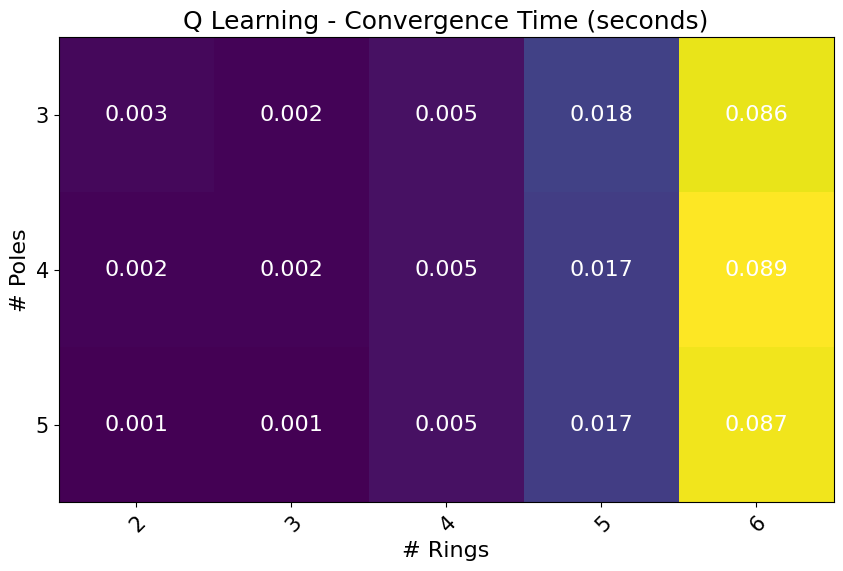

In [14]:
# Reference: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
def plot2():
    f, ax = plt.subplots(1, figsize=(10,10))
    im = ax.imshow(converge_times.transpose())

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(Rs)))
    ax.set_yticks(np.arange(len(Ps)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(Rs,size=15)
    ax.set_yticklabels(Ps,size=15)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(Ps)):
        for j in range(len(Rs)):
            text = ax.text(j, i, converge_times[j, i],
                           ha="center", va="center", color="w",size=16)
    ax.set_title("Q Learning - Convergence Time (seconds)",size=18)
#     fig.tight_layout()
    ax.set_xlabel("# Rings", size=16)
    ax.set_ylabel("# Poles", size=16)
    plt.show()
plot2()

In [33]:
def valueIterateGraph2(t, r):
    max_vs = []
    mean_vs = []
    errors = []
    rewards = []
    iterations = []
    epsilons = list(np.arange(0,1,0.1))
    for epsilon in tqdm(epsilons):
        vi = mdp.QLearning(t, r, gamma=0.9, alpha=0.1, alpha_decay=0.9999, epsilon=epsilon, epsilon_decay=0.99, n_iter=100000)
        vi.run()
        vi.run_stats
        iterations.append(list(range(1,len(vi.run_stats)+1)))
        max_vs.append([el['Max V'] for el in vi.run_stats])
        mean_vs.append([el['Mean V'] for el in vi.run_stats])
        errors.append([el['Error'] for el in vi.run_stats])
        rewards.append([el['Reward'] for el in vi.run_stats])

    f, ax = plt.subplots(2,2, figsize=(15,12))
    print(len(iterations[0]))
    print(len(max_vs[0]))
    ax[0][0].set_title("Max V", fontsize=16)
    for i in range(len(max_vs)):
        ax[0][0].plot(iterations[i], max_vs[i], alpha=1, label="Epsilon: {}".format(np.round(epsilons[i],3)))
        # ax[0][0].plot(iterations[i], max_vs[i], alpha=1)
    ax[0][0].legend()
    ax[0][0].set_xlabel("# Iterations")

    ax[0][1].set_title("Mean V", fontsize=16)
    for i in range(len(mean_vs)):
        ax[0][1].plot(iterations[i], mean_vs[i], alpha=1, label="Epsilon: {}".format(np.round(epsilons[i],3)))
        # ax[0][1].plot(iterations[i], mean_vs[i], alpha=1)
    ax[0][1].legend()
    ax[0][1].set_xlabel("# Iterations")

    ax[1][0].set_title("Error", fontsize=16)
    for i in range(len(errors)):
        ax[1][0].plot(iterations[i], errors[i], alpha=1, label="Epsilon: {}".format(np.round(epsilons[i],3)))
        # ax[1][0].plot(iterations[i], errors[i], alpha=1)
    ax[1][0].legend()
    ax[1][0].set_xlabel("# Iterations")

    ax[1][1].set_title("Reward", fontsize=16)
    for i in range(len(max_vs)):
        ax[1][1].plot(iterations[i], rewards[i], alpha=1, label="Epsilon: {}".format(np.round(epsilons[i],3)))
        # ax[1][1].plot(iterations[i], rewards[i], alpha=1)
    ax[1][1].legend()
    ax[1][1].set_xlabel("# Iterations")
    plt.plot()

100%|██████████| 25/25 [00:34<00:00,  1.37s/it]

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 2

IndexError: invalid index to scalar variable.

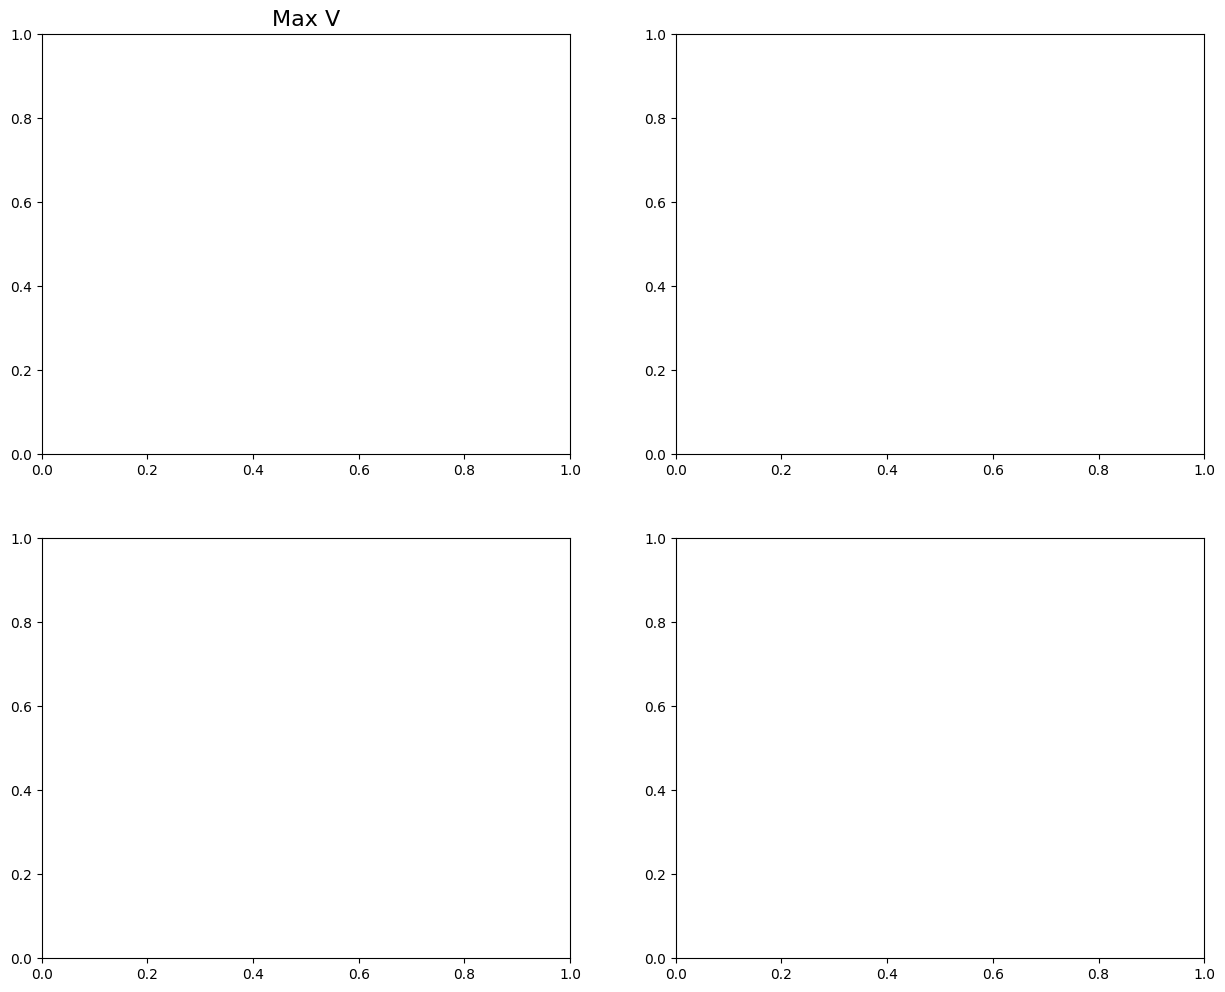

In [23]:
def convert_to_states(p, r):
    # 生成初始状态
    initial_state = tuple(tuple(range(r - 1, -1, -1)) if i == 0 else () for i in range(p))

    # 生成目标状态
    goal_state = tuple(() for _ in range(p - 1)) + (tuple(range(r - 1, -1, -1)),)

    return initial_state, goal_state
initial_state, goal_state = convert_to_states(int(3), int(3))
env = TohEnv(initial_state = initial_state, goal_state = goal_state, noise=0.2)

env.reset()
t, r = getRewardProb(env)


100%|██████████| 25/25 [00:37<00:00,  1.50s/it]


10000
10000


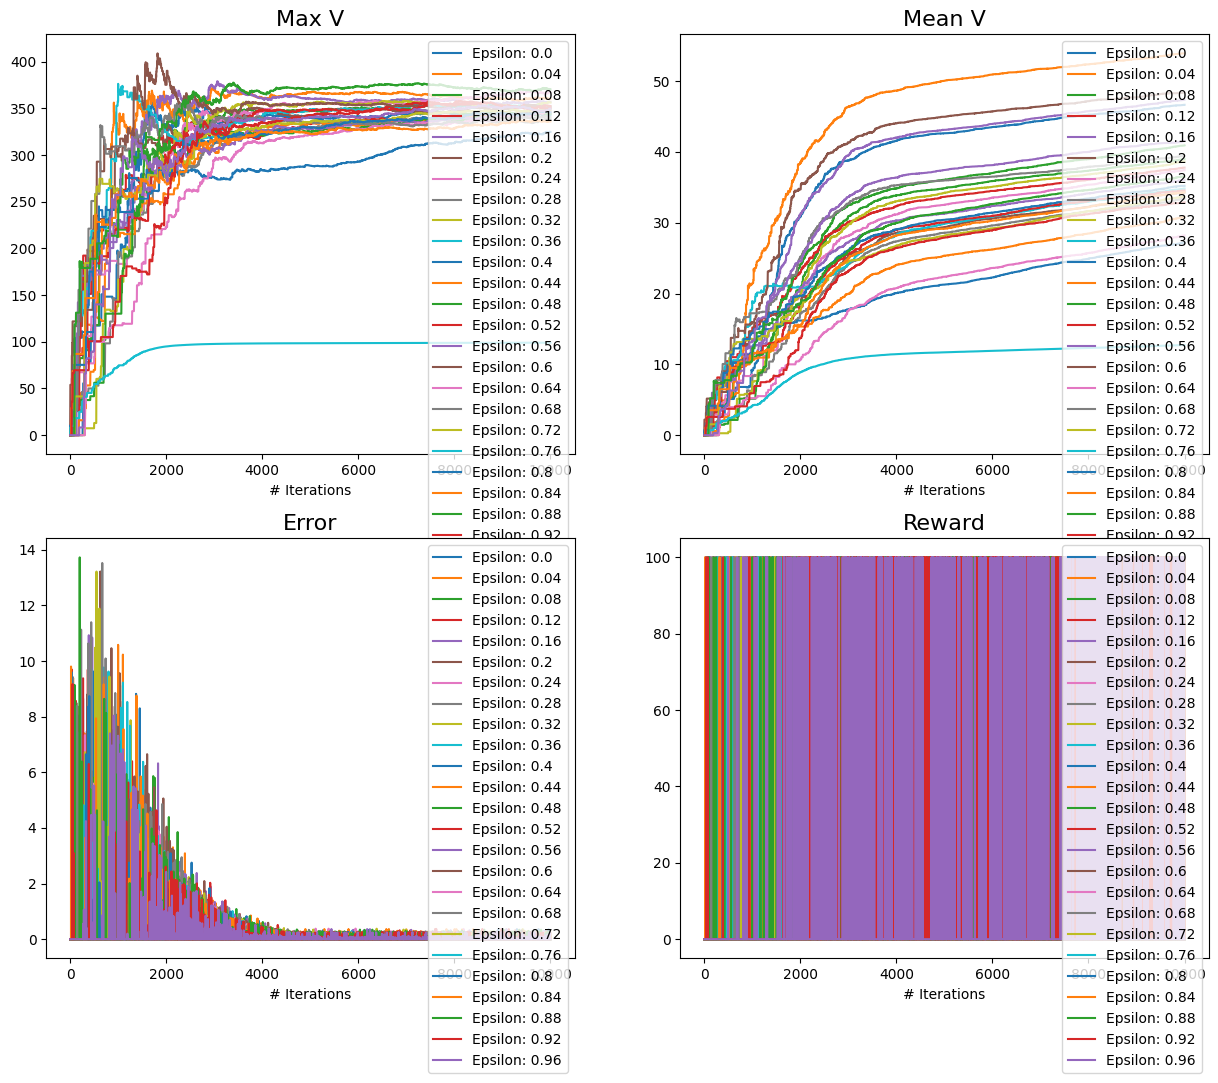

In [34]:
valueIterateGraph2(t, r)

In [16]:
epsilon_3r_3p_0n = [el/100 for el in range(1,100,5)]
n_steps_3r_3p_0n = []
success_rates_3r_3p_0n = []
r, p, n = 3, 3, 0
max_iter=5000
for epsilon in tqdm(epsilon_3r_3p_0n):
    avg_steps, success_rate = runEpisodes(50, 0.9, max_iter, r, p, n, use_vi=False, qlearn=True, epsilon=epsilon)
    n_steps_3r_3p_0n.append(avg_steps)
    success_rates_3r_3p_0n.append(success_rate)

100%|██████████| 20/20 [03:01<00:00,  9.05s/it]


In [18]:
gammas_5r_3p_0n = [el/100 for el in range(1,100,5)]
n_steps_5r_3p_0n = []
success_rates_5r_3p_0n = []
r =6
p =3
n =0
max_iter= 5000
for gamma in tqdm(gammas_5r_3p_0n):
    avg_steps, success_rate = runEpisodes(50, 0.9, max_iter, r, p, n, use_vi=False, qlearn=True, epsilon=epsilon)
    n_steps_5r_3p_0n.append(avg_steps)
    success_rates_5r_3p_0n.append(success_rate)

gammas_3r_3p_0n = [el/100 for el in range(1,100,5)]
n_steps_3r_3p_0n = []
success_rates_3r_3p_0n = []
r, p, n = 3, 3, 0
max_iter=5000
for gamma in tqdm(gammas_3r_3p_0n):
    avg_steps, success_rate = runEpisodes(50, 0.9, max_iter, r, p, n, use_vi=False, qlearn=True, epsilon=epsilon)
    n_steps_3r_3p_0n.append(avg_steps)
    success_rates_3r_3p_0n.append(success_rate)
    
gammas_3r_3p_2n = [el/100 for el in range(1,100,5)]
n_steps_3r_3p_2n = []
success_rates_3r_3p_2n = []
r, p, n = 3, 3, 0.2
max_iter=5000
for gamma in tqdm(gammas_3r_3p_2n):
    avg_steps, success_rate = runEpisodes(50, 0.9, max_iter, r, p, n, use_vi=False, qlearn=True, epsilon=epsilon)
    n_steps_3r_3p_2n.append(avg_steps)
    success_rates_3r_3p_2n.append(success_rate)

gammas_7r_4p_2n = [el/100 for el in range(1,100,5)]
n_steps_7r_4p_2n = []
success_rates_7r_4p_2n = []
r, p, n = 6, 3, 0.2
max_iter=5000
for gamma in tqdm(gammas_7r_4p_2n):
    avg_steps, success_rate = runEpisodes(50, 0.9, max_iter, r, p, n, use_vi=False, qlearn=True, epsilon=epsilon)
    n_steps_7r_4p_2n.append(avg_steps)
    success_rates_7r_4p_2n.append(success_rate)

100%|██████████| 20/20 [16:30<00:00, 49.54s/it]


Text(0.5, 0, 'Gamma')

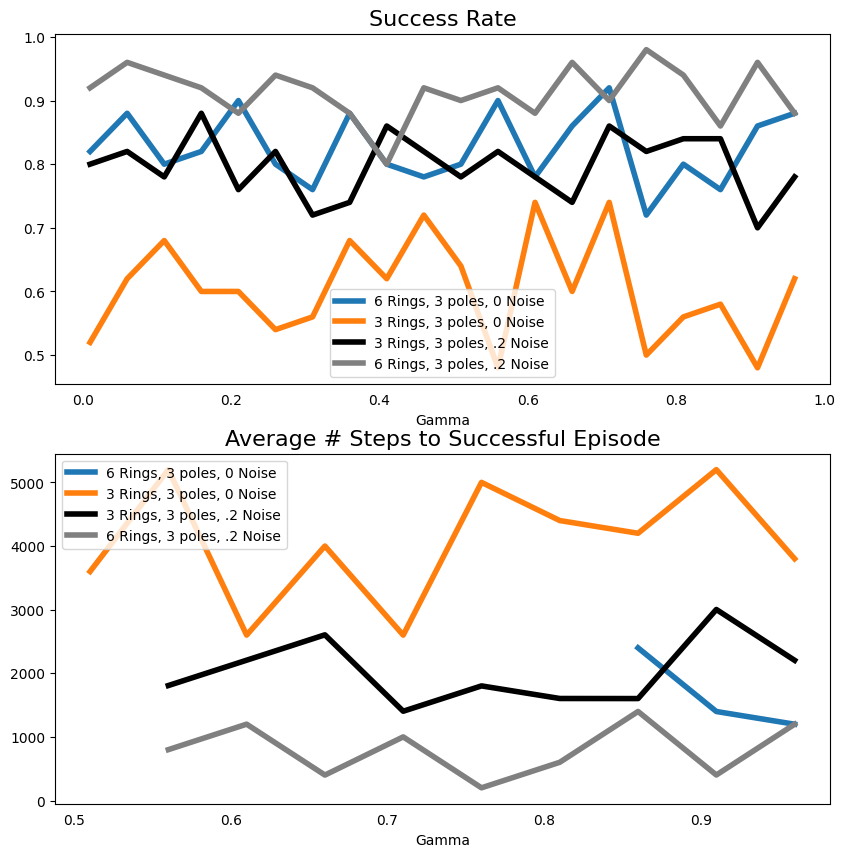

In [19]:
f, ax = plt.subplots(2, figsize=(10,10))
ax[0].set_title("Success Rate", fontsize=16)
ax[0].plot(gammas_5r_3p_0n, success_rates_5r_3p_0n, label="6 Rings, 3 poles, 0 Noise",linewidth=4)
ax[0].plot(gammas_3r_3p_0n, success_rates_3r_3p_0n, label="3 Rings, 3 poles, 0 Noise",linewidth=4)
ax[0].plot(gammas_3r_3p_2n, success_rates_3r_3p_2n, label="3 Rings, 3 poles, .2 Noise",linewidth=4, color='black')
ax[0].plot(gammas_7r_4p_2n, success_rates_7r_4p_2n, label="6 Rings, 3 poles, .2 Noise",linewidth=4, color='gray')
ax[0].tick_params(bottom=False)
ax[0].legend()
ax[0].set_xlabel("Gamma")

ax[1].set_title("Average # Steps to Successful Episode", fontsize=16)
ax[1].plot(gammas_5r_3p_0n[-3:], n_steps_5r_3p_0n[-3:], label="6 Rings, 3 poles, 0 Noise",linewidth=4)
ax[1].plot(gammas_3r_3p_0n[-10:], n_steps_3r_3p_0n[-10:], label="3 Rings, 3 poles, 0 Noise",linewidth=4)
ax[1].plot(gammas_3r_3p_2n[-9:], n_steps_3r_3p_2n[-9:], label="3 Rings, 3 poles, .2 Noise",linewidth=4, color='black')
ax[1].plot(gammas_7r_4p_2n[-9:], n_steps_7r_4p_2n[-9:], label="6 Rings, 3 poles, .2 Noise",linewidth=4, color='gray')
ax[1].tick_params(bottom=False)
ax[1].legend()
ax[1].set_xlabel("Gamma")

Text(0.5, 0, 'Gamma')

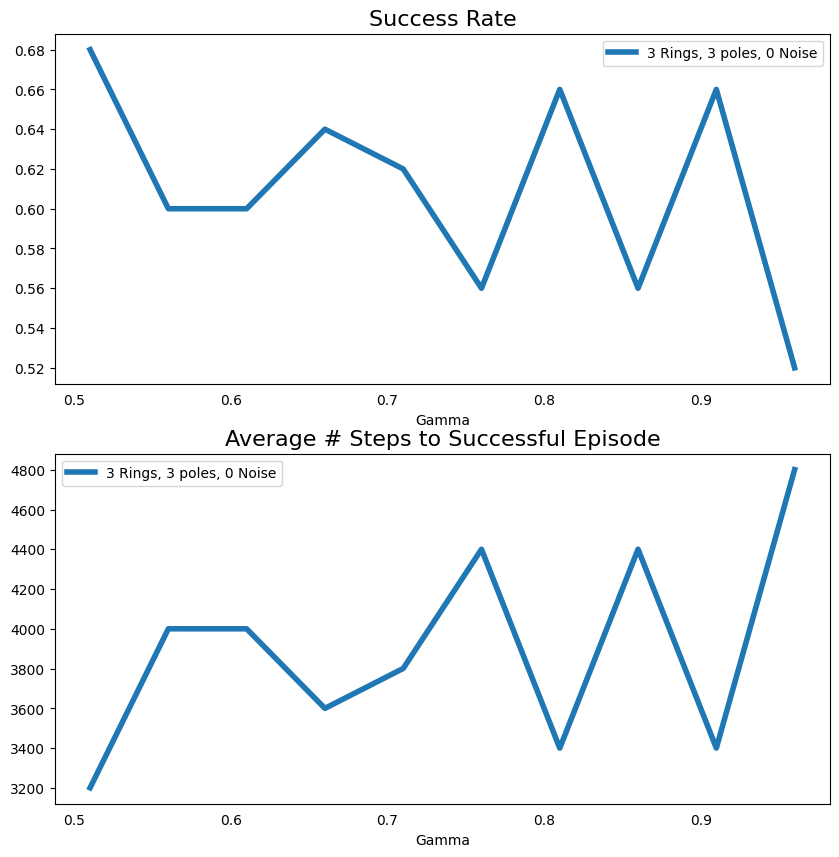

In [17]:
f, ax = plt.subplots(2, figsize=(10,10))
ax[0].set_title("Success Rate", fontsize=16)
ax[0].plot(epsilon_3r_3p_0n[-10:], success_rates_3r_3p_0n[-10:], label="3 Rings, 3 poles, 0 Noise",linewidth=4)
ax[0].tick_params(bottom=False)
ax[0].legend()
ax[0].set_xlabel("Gamma")

ax[1].set_title("Average # Steps to Successful Episode", fontsize=16)
ax[1].plot(epsilon_3r_3p_0n[-10:], n_steps_3r_3p_0n[-10:], label="3 Rings, 3 poles, 0 Noise",linewidth=4)
ax[1].tick_params(bottom=False)
ax[1].legend()
ax[1].set_xlabel("Gamma")